In [1]:
import os
import sys

home=os.path.expanduser("~")
os.environ["SPARK_HOME"]=os.path.join(home, 'spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [2]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder.master("local").appName("myApp").config(conf=myConf).getOrCreate()

# 정보 불러오기

In [3]:
originalMovie = spark.read.csv('data/BigData_171024_191024_toCSV.csv', encoding = 'euc-kr')

In [4]:
originalMovie = originalMovie.drop('_c0')
originalMovie = originalMovie.drop('_c1')
originalMovie = originalMovie.drop('_c2')
originalMovie = originalMovie.drop('_c3')
originalMovie = originalMovie.drop('_c4')
originalMovie = originalMovie.drop('_c6')
originalMovie = originalMovie.drop('_c8')
originalMovie = originalMovie.drop('_c9')
originalMovie = originalMovie.drop('_c10')
originalMovie = originalMovie.drop('_c11')
originalMovie = originalMovie.drop('_c12')
originalMovie = originalMovie.drop('_c13')
originalMovie = originalMovie.drop('_c14')
originalMovie = originalMovie.drop('_c15')

originalMovie.printSchema()

root
 |-- _c5: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)



# 데이터 정제하기

In [5]:
from pyspark.sql import Row

def commaDelete(digit):
    ret = ''
    for ichar in digit:
        if ichar != ',':
            ret += ichar
    return ret

def commaCount(actors):
    cnt = 0
    for idigit in actors:
        if idigit == ',':
            cnt += 1
    return cnt

def getOneDirector(director):
    ret = ''
    directors = director.split(',')
    ret = directors[0]
    return ret

def fiveActors(actors):
    ret = list()
    actor = actors.split(',')
    for i in range(0, 4):
        ret.append(actor[i])
    ret.append(actor[4])
    return ret

cleanedMovie = list()

for movieRow in originalMovie.collect():
    if movieRow._c5 != '0' and movieRow._c7 != '0' and len(movieRow._c16) >= 1 and commaCount(movieRow._c17) >= 4:
        actors = fiveActors(movieRow._c17)
        cleanedMovie.append([int(commaDelete(movieRow._c5)), int(commaDelete(movieRow._c7)), getOneDirector(movieRow._c16), \
                                   actors[0], actors[1], actors[2], actors[3], actors[4]])

# 감독과 배우의 평균 관객수 알아내기

In [6]:
actorToDigit = dict()
directorToDigit = dict()

for elem in cleanedMovie:
    # 감독 평균 관객 동원 수 세기
    if elem[2] not in directorToDigit:
        directorToDigit[elem[2]] = [elem[1], 1]
    else:
        directorToDigit[elem[2]][0] += elem[1]
        directorToDigit[elem[2]][1] += 1
    # 배우 평균 관객 동원 수 세기
    if elem[3] not in actorToDigit:
        actorToDigit[elem[3]] = [elem[1], 1]
    else:
        actorToDigit[elem[3]][0] += elem[1]
        actorToDigit[elem[3]][1] += 1
    if elem[4] not in actorToDigit:
        actorToDigit[elem[4]] = [elem[1], 1]
    else:
        actorToDigit[elem[4]][0] += elem[1]
        actorToDigit[elem[4]][1] += 1
    if elem[5] not in actorToDigit:
        actorToDigit[elem[5]] = [elem[1], 1]
    else:
        actorToDigit[elem[5]][0] += elem[1]
        actorToDigit[elem[5]][1] += 1
    if elem[6] not in actorToDigit:
        actorToDigit[elem[6]] = [elem[1], 1]
    else:
        actorToDigit[elem[6]][0] += elem[1]
        actorToDigit[elem[6]][1] += 1
    if elem[7] not in actorToDigit:
        actorToDigit[elem[7]] = [elem[1], 1]
    else:
        actorToDigit[elem[7]][0] += elem[1]
        actorToDigit[elem[7]][1] += 1

In [7]:
actorOfMeanValue = dict()
for k, v in actorToDigit.iteritems():
    actorOfMeanValue[k] = v[0]/v[1]
    
directorOfMeanValue = dict()
for k, v in directorToDigit.iteritems():
    directorOfMeanValue[k] = v[0]/v[1]

# Dataframe 준비하기

In [8]:
digitMovieList = list()
MOVIE = Row('Cumulative_Dollar', 'Cumulative_Customer', 'Director', 'Actor') 
for elem in cleanedMovie:
    digitMovieList.append(Row(elem[0], elem[1], directorOfMeanValue[elem[2]], \
                              (actorOfMeanValue[elem[3]]+actorOfMeanValue[elem[4]]+\
                               actorOfMeanValue[elem[5]]+actorOfMeanValue[elem[6]]+actorOfMeanValue[elem[7]])/5))

In [9]:
movieDf=spark.createDataFrame(digitMovieList, ['Cumulative_Dollar', 'Cumulative_Customer', 'Director', 'Actor'])
moviePandas = movieDf.toPandas()

# Dataframe에 잘 들어있는지 확인

In [10]:
movieDf.printSchema()
for elem in movieDf.take(10):
    for ee in elem:
        print ee,
    print 

root
 |-- Cumulative_Dollar: long (nullable = true)
 |-- Cumulative_Customer: long (nullable = true)
 |-- Director: long (nullable = true)
 |-- Actor: long (nullable = true)

139648729516 16265094 8729661 5989556
115707150137 14411689 9339002 7768933
102677166409 12276258 9339002 6114221
85865876245 10083172 5557275 4004263
79157022362 9414943 9414943 4802614
58169776145 7232387 7232387 4931902
46342006026 5441020 5441020 3989550
44356976474 5294154 4571927 4219709
43486831113 5063844 1852717 2913548
42795690816 4975517 2493153 4667122


# VectorAssembler로 회귀분석

In [11]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Director', 'Actor'], outputCol = 'features')
movieFeatures = vectorAssembler.transform(movieDf)
movieFeatures.show(10)

+-----------------+-------------------+--------+-------+--------------------+
|Cumulative_Dollar|Cumulative_Customer|Director|  Actor|            features|
+-----------------+-------------------+--------+-------+--------------------+
|     139648729516|           16265094| 8729661|5989556|[8729661.0,598955...|
|     115707150137|           14411689| 9339002|7768933|[9339002.0,776893...|
|     102677166409|           12276258| 9339002|6114221|[9339002.0,611422...|
|      85865876245|           10083172| 5557275|4004263|[5557275.0,400426...|
|      79157022362|            9414943| 9414943|4802614|[9414943.0,480261...|
|      58169776145|            7232387| 7232387|4931902|[7232387.0,493190...|
|      46342006026|            5441020| 5441020|3989550|[5441020.0,398955...|
|      44356976474|            5294154| 4571927|4219709|[4571927.0,421970...|
|      43486831113|            5063844| 1852717|2913548|[1852717.0,291354...|
|      42795690816|            4975517| 2493153|4667122|[2493153

In [12]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='Cumulative_Customer')
lr_model = lr.fit(movieFeatures)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))
print("R squared: " + str( lr_model.summary.r2))
print ("pvalue: " + str(lr_model.summary.pValues))
print ("tvalue: " + str(lr_model.summary.tValues))

Coefficients: [0.46233117467589313,1.0013328824367156]
Intercept: -924248.227636
R squared: 0.806762475798
pvalue: [0.0, 0.0, 4.218847493575595e-15]
tvalue: [10.073770523769655, 14.935630544640789, -8.212842706246622]


# statsmodels로 회귀분석하기

In [14]:
import statsmodels.formula.api as sm

result = sm.ols(formula = 'Cumulative_Customer ~ Director + Actor', data = moviePandas).fit()
print result.summary()

                             OLS Regression Results                            
Dep. Variable:     Cumulative_Customer   R-squared:                       0.807
Model:                             OLS   Adj. R-squared:                  0.806
Method:                  Least Squares   F-statistic:                     728.5
Date:                 Fri, 06 Dec 2019   Prob (F-statistic):          2.65e-125
Time:                         21:37:11   Log-Likelihood:                -5480.9
No. Observations:                  352   AIC:                         1.097e+04
Df Residuals:                      349   BIC:                         1.098e+04
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.242e+05   1.13e+05     -8.21

# 회귀식 정리하기
## Cumulative_Customer = 0.4623 * Director + 1.0013 * Actor - 924,200

In [16]:
import pandas as pd
import numpy as np
a, b = np.meshgrid(np.linspace(moviePandas.Director.min(),moviePandas.Director.max(),100),\
                   np.linspace(moviePandas.Actor.min(),moviePandas.Actor.max(),100))

x_ax = pd.DataFrame({'Director': a.ravel(), 'Actor': b.ravel()})
y = result.predict(exog = x_ax)

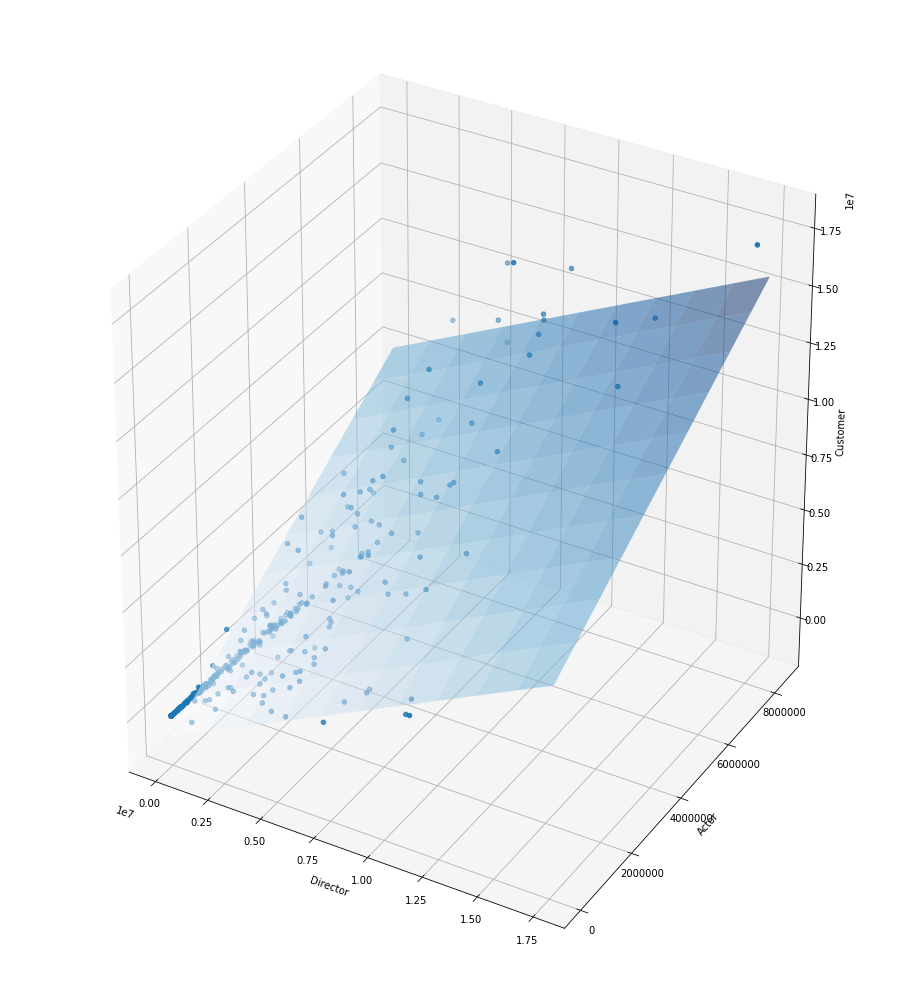

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(16, 18))
ax = fig.gca(projection='3d')

X = moviePandas.Director.to_list()
Y = moviePandas.Actor.to_list()
Z = moviePandas.Cumulative_Customer.to_list()

ax.scatter3D(X, Y, Z)
ax.plot_surface(a,b,y.values.reshape(a.shape), rstride=10, cstride=10, cmap=cm.Blues, alpha = 0.5)

ax.set_xlabel('Director')
ax.set_ylabel('Actor')
ax.set_zlabel('Customer')

plt.show()

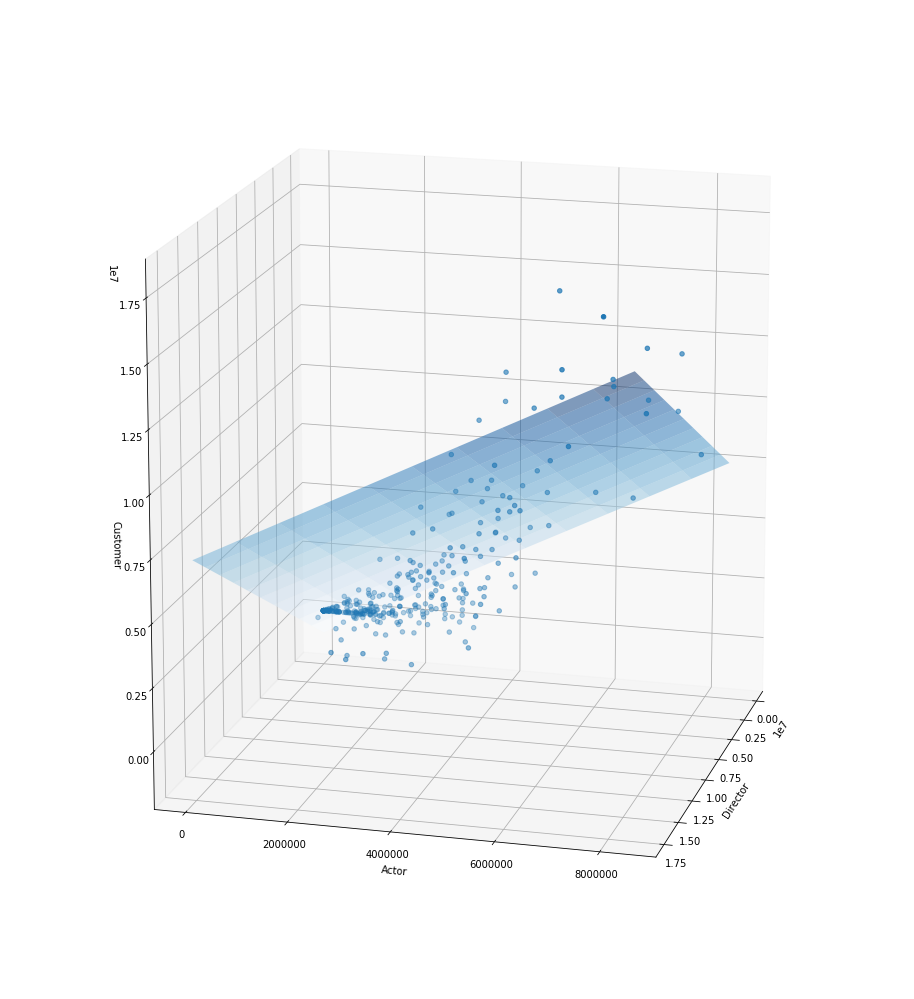

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(16, 18))
ax = fig.gca(projection='3d')

X = moviePandas.Director.to_list()
Y = moviePandas.Actor.to_list()
Z = moviePandas.Cumulative_Customer.to_list()

ax.scatter3D(X, Y, Z)
ax.plot_surface(a,b,y.values.reshape(a.shape), rstride=10, cstride=10, cmap=cm.Blues, alpha = 0.5)

ax.set_xlabel('Director')
ax.set_ylabel('Actor')
ax.set_zlabel('Customer')

ax.view_init(15, 15)

plt.show()

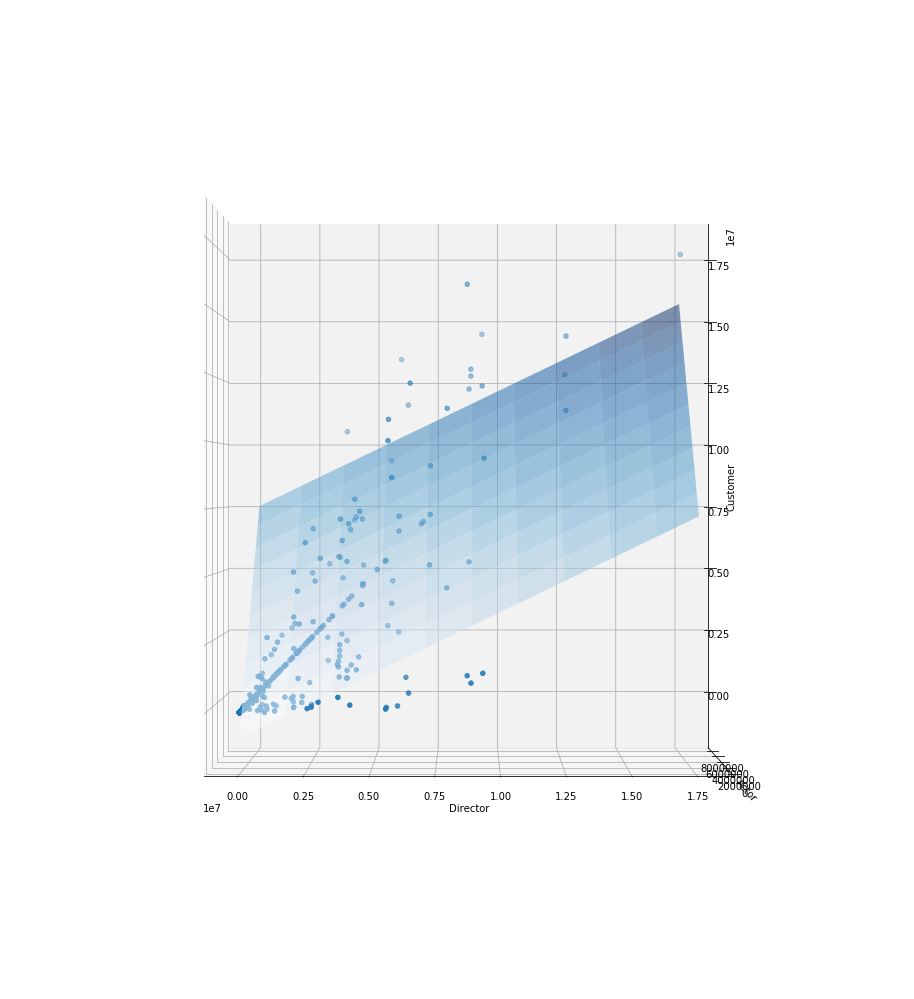

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(16, 18))
ax = fig.gca(projection='3d')

X = moviePandas.Director.to_list()
Y = moviePandas.Actor.to_list()
Z = moviePandas.Cumulative_Customer.to_list()

ax.scatter3D(X, Y, Z)
ax.plot_surface(a,b,y.values.reshape(a.shape), rstride=10, cstride=10, cmap=cm.Blues, alpha = 0.5)

ax.set_xlabel('Director')
ax.set_ylabel('Actor')
ax.set_zlabel('Customer')

ax.view_init(0, -90)

plt.show()

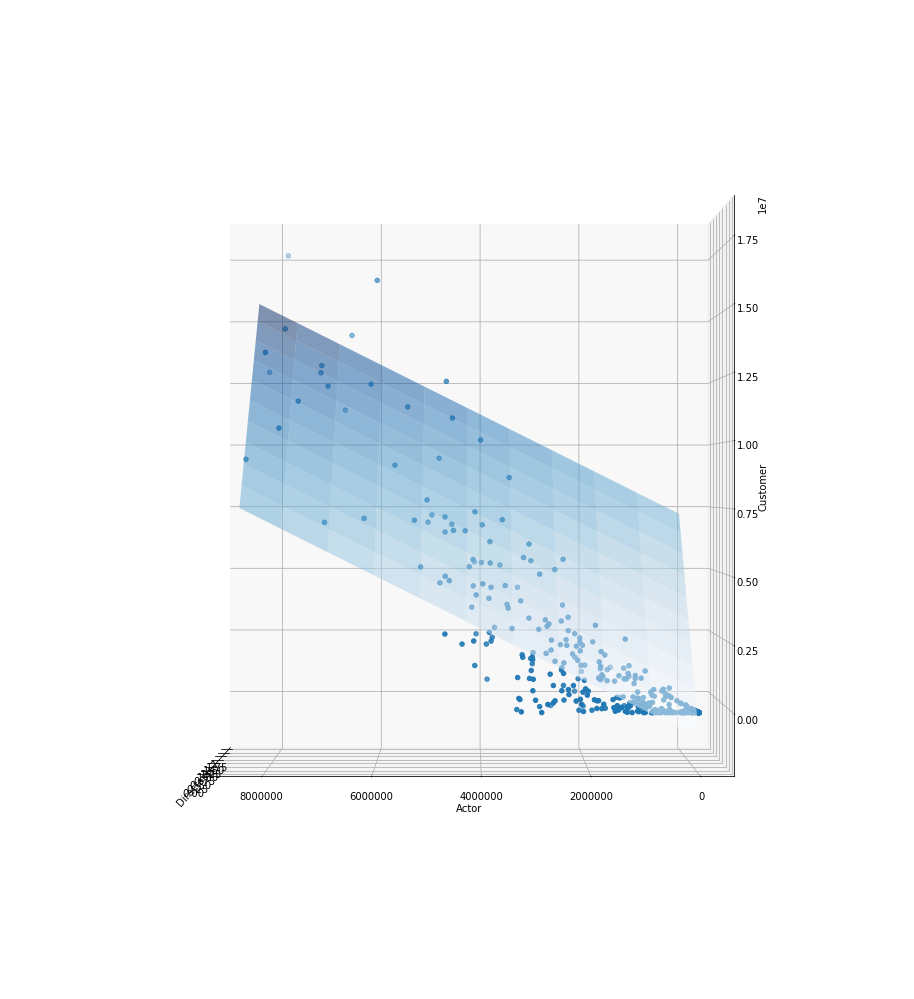

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(16, 18))
ax = fig.gca(projection='3d')

X = moviePandas.Director.to_list()
Y = moviePandas.Actor.to_list()
Z = moviePandas.Cumulative_Customer.to_list()

ax.scatter3D(X, Y, Z)
ax.plot_surface(a,b,y.values.reshape(a.shape), rstride=10, cstride=10, cmap=cm.Blues, alpha = 0.5)

ax.set_xlabel('Director')
ax.set_ylabel('Actor')
ax.set_zlabel('Customer')

ax.view_init(0, 180)

plt.show()

# 정확도 판단하기

In [41]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

train, test = train_test_split(moviePandas, train_size=0.8)

ytrain = train['Cumulative_Customer']
xtrain = train.drop(['Cumulative_Dollar','Cumulative_Customer'], axis=1)

ytest = test['Cumulative_Customer']
xtest = test.drop(['Cumulative_Dollar','Cumulative_Customer'], axis=1)

In [42]:
regression = linear_model.LinearRegression()
regression.fit(xtrain, ytrain)

accuracy = regression.score(xtest,ytest)
print str(accuracy*100) +'%'

87.46878652019666%


# 예측하기

In [81]:
def calculate(director, actors):
    ret = 0
    if director not in directorOfMeanValue:
        ret += moviePandas.Director.median()
    else:
        ret += 0.4623 * directorOfMeanValue[director]
    
    tmp = 0
    for actor in actors:
        if actor not in actorOfMeanValue:
            tmp += moviePandas.Actor.median()
        else:
            tmp += actorOfMeanValue[actor]
    tmp /= 5
    ret += 1.0013 * tmp
    ret -= 924200
    return ret

# 나쁜 녀석들: 더 무비 4573371
print ('나쁜 녀석들: 더 무비 4573371')
print calculate(u'손용호', [u'마동석', u'김상중', u'김아중', u'장기용', u'박효주'])
print '\n'
# 타짜: 원 아이드 잭 2229239
print ('타짜: 원 아이드 잭 2229239')
print calculate(u'권오광', [u'박정민', u'류승범', u'최유화', u'우현', u'윤제문'])
print '\n'
# 가장 보통의 연애 2924471 
print ('가장 보통의 연애 2924471')
print calculate(u'김한결', [u'김래원', u'공효진', u'강기영', u'정웅인', u'장소연'])
print '\n'
# 양자물리학 554093
print ('양자물리학 554093')
print calculate(u'이성태', [u'박해수', u'서예지', u'김상호', u'김응수', u'변희봉'])
print '\n'
# 장사리 : 잊혀진 영웅들 1137745
print ('장사리 : 잊혀진 영웅들 1137745')
print calculate(u'곽경택', [u'김명민', u'최민호', u'김성철', u'김인권', u'곽시양'])
print '\n'
# 퍼펙트맨 1239590
print ('퍼펙트맨 1239590 (fail)')
print calculate(u'용수', [u'설경구', u'조진웅', u'허준호', u'진선규', u'지승현'])
print '\n'
# 82년생 김지영 3672387
print ('82년생 김지영 3672387 (fail)')
print calculate(u'김도영', [u'정유미', u'공유', u'김미경', u'공민정', u'박성연'])

나쁜 녀석들: 더 무비 4573371
5184419.83178


타짜: 원 아이드 잭 2229239
2808466.9345


가장 보통의 연애 2924471
2469661.3325


양자물리학 554093
718400.1489


장사리 : 잊혀진 영웅들 1137745
952628.3035


퍼펙트맨 1239590 (fail)
2745891.2181


82년생 김지영 3672387 (fail)
1364712.1632


In [80]:
print ('시동?')
print calculate(u'최정열', [u'마동석', u'박정민', u'정해인', u'염정아', u'고두심'])
print '\n'
print ('백두산?')
print calculate(u'이해준', [u'이병헌', u'하정우', u'마동석', u'전혜진', u'배수지'])
print '\n'
print ('천문: 하늘에 묻는다?')
print calculate(u'허진호', [u'최민식', u'한석규', u'신구', u'김홍파', u'허준호'])

시동?
2542022.4765000003


백두산?
3773479.7155


천문: 하늘에 묻는다?
2928369.8951
